In [140]:
import sys
import pandas as pd 
import numpy as np 
import seaborn as sns
import tensorflow.keras 
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from sklearn.preprocessing import MinMaxScaler

In [141]:
dfstocks = pd.read_csv('S&Pfinancedata.csv',parse_dates = True)
dftweets = pd.read_csv('sandp500processedVADER.csv', parse_dates = True)

In [153]:
rowsdifference = dfstocks.iloc[:, 5]
dfstocks['Difference'] = rowsdifference.diff()
dfstocks['Date'] = pd.to_datetime(dfstocks['Date'])
dfstocks['Difference'].iloc[0] = 0
dftweets['date'] = pd.to_datetime(dftweets['date'])
dftweets = dftweets.groupby(['date'], as_index = False ).mean().sort_values('compound', ascending= True).reset_index()
dftweets.sort_values('date', inplace=True, ascending=True)
merged = pd.merge(left=dftweets, left_on='date',
         right=dfstocks, right_on='Date')
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','compound','Close']]
#merged = merged[1:]

for i in range(merged.shape[0]):
    if merged['Difference'].iloc[i] >= 0:
        merged['Difference'].iloc[i] = 1
    else:
        merged['Difference'].iloc[i] = 0
merged.head()

,level_0,date,index,Unnamed: 0,Unnamed: 0.1,id,replyCount,retweetCount,likeCount,quoteCount,...,neutral,compound,Date,Open,High,Low,Close,Adj Close,Volume,Difference
0,0,2018-06-01,0,84226.0,156854.766497,1.002536e+18,0.081218,0.299492,0.984772,0.030457,...,0.881005,0.041797,2018-06-01,2718.699951,2736.929932,2718.699951,2734.620117,2734.620117,3684130000,1.0
1,3,2018-06-04,3,83815.0,156137.213483,1.003659e+18,0.213483,0.475655,1.936330,0.086142,...,0.846801,0.145254,2018-06-04,2741.669922,2749.159912,2740.540039,2746.870117,2746.870117,3376510000,1.0
2,4,2018-06-05,4,83515.5,155581.213855,1.003993e+18,0.168675,0.403614,2.147590,0.054217,...,0.858431,0.170254,2018-06-05,2748.459961,2752.610107,2739.510010,2748.800049,2748.800049,3517790000,1.0
3,5,2018-06-06,5,83227.5,155066.151639,1.004359e+18,0.110656,0.290984,0.831967,0.020492,...,0.845963,0.124826,2018-06-06,2753.250000,2772.389893,2748.459961,2772.350098,2772.350098,3651640000,1.0
4,6,2018-06-07,6,82997.0,154606.746544,1.004709e+18,0.110599,0.253456,0.797235,0.023041,...,0.862788,0.071476,2018-06-07,2774.840088,2779.899902,2760.159912,2770.370117,2770.370117,3711330000,0.0


In [154]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

'''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 1])
    return np.array(dataX), np.array(dataY)
'''


'\ndef create_dataset(dataset, look_back=1):\n    dataX, dataY = [], []\n    for i in range(len(dataset) - look_back - 1):\n        a = dataset[i:(i + look_back), :]\n        dataX.append(a)\n        dataY.append(dataset[i + look_back, 1])\n    return np.array(dataX), np.array(dataY)\n'

In [155]:
n_days = 2
n_features = 7
dataset = merged_sim.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = series_to_supervised(dataset, n_days,1)

droplist = []
for i in range(n_features*n_days, n_features*n_days + 6):
    droplist.append(i)
print(droplist)
dataset.drop(dataset.columns[droplist], axis = 1, inplace = True)
dataset

[14, 15, 16, 17, 18, 19]


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
2,0.603486,0.600581,0.627764,0.644864,0.341171,0.323692,0.644864,0.642470,0.623071,0.664608,0.665462,0.289534,0.812187,0.665462,0.668707
3,0.642470,0.623071,0.664608,0.665462,0.289534,0.812187,0.665462,0.653994,0.629416,0.662871,0.668707,0.313249,0.930231,0.668707,0.708305
4,0.653994,0.629416,0.662871,0.668707,0.313249,0.930231,0.668707,0.662124,0.665790,0.677969,0.708305,0.335717,0.715732,0.708305,0.704975
5,0.662124,0.665790,0.677969,0.708305,0.335717,0.715732,0.708305,0.698766,0.679600,0.697707,0.704975,0.345737,0.463829,0.704975,0.719537
6,0.698766,0.679600,0.697707,0.704975,0.345737,0.463829,0.704975,0.683492,0.678663,0.703494,0.719537,0.247015,0.671708,0.719537,0.724530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0.836612,0.836959,0.851140,0.849411,0.258648,0.286275,0.849411,0.803754,0.784053,0.774179,0.792191,0.376061,0.450110,0.792191,0.798615
247,0.803754,0.784053,0.774179,0.792191,0.376061,0.450110,0.792191,0.796473,0.792623,0.798977,0.798615,0.207431,0.447168,0.798615,0.758815
248,0.796473,0.792623,0.798977,0.798615,0.207431,0.447168,0.798615,0.792434,0.791059,0.767582,0.758815,0.414573,0.503300,0.758815,0.726246
249,0.792434,0.791059,0.767582,0.758815,0.414573,0.503300,0.758815,0.724920,0.701907,0.707661,0.726246,0.343844,0.271933,0.726246,0.736065


In [156]:
train_size = int(merged.shape[0]*0.67)

n_obs = n_days * n_features
values = dataset.values
train, test =  values[0:train_size, :], values[train_size:len(values), :]
train_X, train_y = train[:,:n_obs], train[:,-n_features]
test_X, test_y = test[:,:n_obs], test[:,-n_features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

In [157]:
batch_size = 32
epochs = 50
np.random.seed(420)

Train on 168 samples, validate on 81 samples
Epoch 1/50
168/168 [==============================] - 2s 13ms/sample - loss: 0.3897 - acc: 0.0060 - val_loss: 0.3695 - val_acc: 0.0000e+00
Epoch 2/50
168/168 [==============================] - 0s 488us/sample - loss: 0.1968 - acc: 0.0060 - val_loss: 0.1164 - val_acc: 0.0123
Epoch 3/50
168/168 [==============================] - 0s 440us/sample - loss: 0.0597 - acc: 0.0060 - val_loss: 0.0028 - val_acc: 0.0123
Epoch 4/50
168/168 [==============================] - 0s 554us/sample - loss: 0.0657 - acc: 0.0060 - val_loss: 0.0113 - val_acc: 0.0123
Epoch 5/50
168/168 [==============================] - 0s 649us/sample - loss: 0.0449 - acc: 0.0060 - val_loss: 0.0076 - val_acc: 0.0123
Epoch 6/50
168/168 [==============================] - 0s 637us/sample - loss: 0.0337 - acc: 0.0060 - val_loss: 0.0284 - val_acc: 0.0123
Epoch 7/50
168/168 [==============================] - 0s 446us/sample - loss: 0.0414 - acc: 0.0060 - val_loss: 0.0219 - val_acc: 0.0123


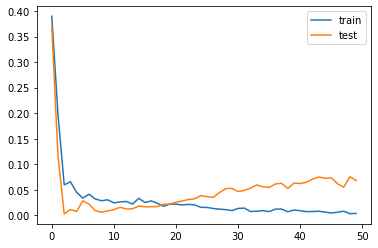

In [159]:
model = Sequential()
model.add(LSTM(128, dropout=0.4, recurrent_dropout = 0.4,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(96, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_X, train_y,
                validation_data = (test_X, test_y),
                batch_size=batch_size,
                epochs=epochs)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [160]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 128)               69632     
_________________________________________________________________
dense_35 (Dense)             (None, 96)                12384     
_________________________________________________________________
dense_36 (Dense)             (None, 16)                1552      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 17        
Total params: 83,585
Trainable params: 83,585
Non-trainable params: 0
_________________________________________________________________


In [161]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, (-1 * n_features + 1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [162]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, (-1 * n_features + 1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [163]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print(rmse)

153.77406


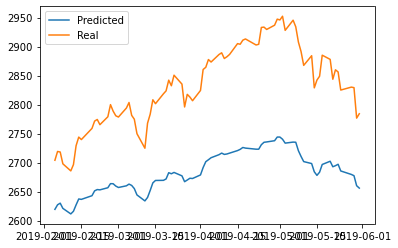

In [180]:
x = merged['Date'][train_size+2:]
plt.plot(x,inv_yhat, label = "Predicted")
plt.plot(x,inv_y, label = "Real")
#plt.plot(x, merged['Close'][train_size:len(merged)-2], label = "Close")
plt.legend()

In [175]:
print(merged['Close'][len(merged)-1])
print(inv_y)

2752.06005859375
[2704.0513 2719.2097 2718.2346 2697.9075 2685.718  2696.5315 2729.1887
 2743.9897 2739.7097 2758.9534 2771.5981 2774.361  2765.368  2779.0417
 2799.943  2788.707  2780.7324 2778.5327 2794.0164 2803.616  2781.469
 2774.7837 2749.8408 2724.7898 2767.99   2783.506  2808.3403 2801.5793
 2818.623  2823.6938 2842.1245 2832.5032 2850.6738 2835.3416 2795.934
 2817.6914 2813.0212 2806.6826 2824.3657 2860.523  2864.3152 2877.6968
 2873.3953 2886.3542 2889.2905 2879.463  2882.5293 2886.5493 2905.099
 2904.081  2911.0803 2913.1824 2902.7803 2903.9832 2933.0217 2933.5852
 2929.5435 2936.8896 2947.3352 2945.9265 2952.33   2928.0051 2945.526
 2934.1162 2907.797  2891.4685 2867.6416 2884.2632 2828.8733 2842.255
 2848.9075 2885.173  2877.946  2843.6853 2859.9595 2856.265  2825.0918
 2830.141  2829.22   2776.6907 2784.243 ]
